In [3]:
import numpy as np
import os
import time
import sys
import torch 

import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt



# Intro


## Create Random Problem


In [ ]:
#just any help function needed to make plots/ create problem
def create_domain(dim = 2,bound = 5):
    #dim is the number of x_i we allow; bound is just the maximal absolute value we allow the intervals to contain
    
    lb,ub = ((2* torch.rand(dim) -1))*bound,((2* torch.rand(dim) -1))*bound
    lb,ub = torch.min(lb,ub), torch.max(lb,ub)
    for i in range(dim):
        assert lb[i]<= ub[i]
    return (lb,ub)
def get_concrete_bounds(bounds, sensitivity,bias):

    pos_sens = torch.where(sensitivity >= 0,sensitivity, torch.zeros_like(sensitivity))
    neg_sens = torch.where(sensitivity < 0,sensitivity, torch.zeros_like(sensitivity))
    
    lb = bias + (pos_sens * bounds[0] + neg_sens * bounds[1]).sum()
    ub = bias + (pos_sens * bounds[1] + neg_sens * bounds[0]).sum()
    return (lb,ub)
    

def create_linear_constraints(domain,num_constraints = 2, bound = 3):
    #domain is input domain, num_constraints defines how many sets we want to obtain; bound is the maximal 
    #abs value of coefs I allow
    #First randomly fix z = temp1 * 1 + temp2 *x2 + temp_0
    constraints = []
    dim = domain[0].shape[0] + 1 # +1 due to bias term
    temp = ((2* torch.rand(dim) -1))*(bound/2) # smaller than bound in order to allow creation of low and upp bounds
    for i in range(num_constraints):
        c = 0
        while True:
            if c >= 60* (i+1):
                return None,None
            lower = ((2* torch.rand(dim) -1))*bound 
            lb,ub = get_concrete_bounds(domain, temp[1:] - lower[1:],temp[0] - lower[0])
            c+= 1
            if lb < 0:
                lower[0] += lb - 1e-6
            if lower[0].abs() > bound:
                continue
            break
        c = 0       
        while True:
            if c >= 60* (i+1):
                return None,None
            upper = ((2* torch.rand(dim) -1))*bound 
            lb,ub = get_concrete_bounds(domain, upper[1:] - temp[1:],upper[0] - temp[0])
            c+= 1
            if lb < 0:
                upper[0] -= lb - 1e-6
                
            if upper[0].abs() > bound:
                continue
            break
        constraints.append((lower,upper))
        
    return constraints, temp

def make_3d_plot(domain,constraints,temp = None, mode = None, colors = 'g',savename=None):
    %matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x1 = np.linspace(domain[0][0].item(), domain[1][0].item(), 100)
    x2 = np.linspace(domain[0][1].item(), domain[1][1].item(), 100)
    x1, x2 = np.meshgrid(x1, x2)
    z_low = constraints[0][0][0] +constraints[0][0][1] *x1 + constraints[0][0][2] *x2
    z_upp = constraints[0][1][0] +constraints[0][1][1] *x1 + constraints[0][1][2] *x2
    for i in range(1,len(constraints)):
        z_low = np.minimum(z_low,constraints[i][0][0] +constraints[i][0][1] *x1 + constraints[i][0][2] *x2)
        z_upp = np.maximum(z_upp,constraints[i][1][0] +constraints[i][1][1] *x1 + constraints[i][1][2] *x2)

    # Plot the surface
    if mode in [None,"low"]:
        ax.plot_surface(x1, x2, z_low,color = 'r',label = "lower")
    if mode in [None,"upp"]:
        ax.plot_surface(x1, x2, z_upp,color ='b',label = "upper")

    
    if temp is not None:
        for k in range(len(temp)):
            z = temp[k][0] +temp[k][1] *x1 + temp[k][2] *x2 
            ax.plot_surface(x1, x2, z, color = colors,label = "overapproximation")
            
    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    ax.set_zlabel('x')
    plt.xticks(color='w')
    plt.yticks(color='w')
    for t in ax.zaxis.get_major_ticks(): 
        t.label.set_color('w')
    #ax.zaxis.set_ticks(ax.zaxis.get_major_ticks(),color='w')
    
    if mode == "low":
        ax.azim = 163
        ax.elev = 20
    elif mode == "upp":
        ax.azim = -23
        ax.elev = 15
    else:
        ax.azim = -47
        ax.elev = 27
    #azi -62
    #elevation 22
    #plt.xticks(plt.get_xticks, [])
    #plt.yticks()
    #ax.zaxis.set_ticks([])
    #plt.zticks([])
    if savename != None:
        plt.savefig(savename)

    plt.show()
    

## Curls


In [ ]:
def order_constraints(constraints,domain):
    #We can completely split the lowerbound constraints from the upperbound constraints
    lower = []
    upper = []
    concrete_low = []
    concrete_upp = []
    for i in range(len(constraints)):
        lower.append(constraints[i][0])
        upper.append(constraints[i][1])
        concrete_low.append(get_concrete_bounds(domain, constraints[i][0][1:],constraints[i][0][0]))
        concrete_upp.append(get_concrete_bounds(domain, constraints[i][1][1:],constraints[i][1][0]))
        
    sort = sorted(range(len(concrete_low)), key=lambda m: concrete_low[m][0]) 
    concrete_low = [concrete_low[m] for m in sort]
    lower = [lower[m] for m in sort]

    sort = sorted(range(len(concrete_upp)), key=lambda m: concrete_upp[m][1],reverse = True) 
    concrete_upp = [concrete_upp[m] for m in sort]
    upper = [upper[m] for m in sort]
    
    return lower,upper, concrete_low, concrete_upp
    
def relu_method(constraints,domain,mode = False):
    lower,upper, concrete_low, concrete_upp = order_constraints(constraints,domain)
    #first get lowerbound of lowerbounds
    counter = 0
    while len(lower)> 1:
        #since sorted accourding to increasing lowerbound, as soon as condition is true we have already minimum
        if ((concrete_low[0][1] <= concrete_low[1][0])):
            break
            
        x0,_ = lower.pop(0), concrete_low.pop(0)
        x1,_ = lower.pop(0), concrete_low.pop(0)
        
        lb, ub = get_concrete_bounds(domain, x0[1:] - x1[1:],x0[0] - x1[0])
        
        if ub <= 0:
            z = x0
        elif lb >= 0:
            z = x1
        else:
            counter += 1
            z = x0 * (-lb) + x1 * ub
            z[0] += ub * lb
            z /= (ub-lb) 
        lower.insert(0,z)
        concrete_low.insert(0,(get_concrete_bounds(domain,z[1:],z[0])))
        
    while len(upper)> 1:
        #since sorted accourding to increasing lowerbound, as soon as condition is true we have already minimum
        if ((concrete_upp[1][1] <= concrete_upp[0][0])):
            break
            
        x0,_ = upper.pop(0), concrete_upp.pop(0)
        x1,_ = upper.pop(0), concrete_upp.pop(0)
        
        lb, ub = get_concrete_bounds(domain, x0[1:] - x1[1:],x0[0] - x1[0])
        
        if ub <= 0:
            z = x1
        elif lb >= 0:
            z = x0
        else:
            counter+= 1
            z = x1 * (-lb) + x0 * ub
            z[0] -= ub * lb
            z /= (ub-lb) 
        upper.insert(0,z)
        concrete_upp.insert(0,(get_concrete_bounds(domain,z[1:],z[0])))
    
    if mode:
        return lower[0],upper[0],counter
    return lower[0],upper[0]
    

## LP-Solver Variant

In [ ]:
def get_all_corners_and_func_values(constraints,lb,ub):
    lb = lb.clone()
    ub = ub.clone()
    corners = torch.tensor([lb[0],ub[0]])
    for j in range(1,ub.shape[0]):
        temp = torch.tensor([lb[j],ub[j]]).view(1,2)
        corners = [torch.cat((corners[x].view(1,-1),temp[:,y].view(1,-1)),dim = 1) for x in range(2 ** j) for y in range(2)]
    samples = torch.tensor([])
    for x in corners:
        samples = torch.cat((samples,x),dim = 0)
    corners = samples
    lower,upper, _, _ = order_constraints(constraints,(lb,ub))
    g_low = lower[0][0] + corners.matmul(lower[0][1:])
    g_upp = upper[0][0] + corners.matmul(upper[0][1:])
    for k in range(1,len(lower)):
        g_low = torch.minimum(g_low,lower[k][0] + corners.matmul(lower[k][1:]))
        g_upp = torch.maximum(g_upp,upper[k][0] + corners.matmul(upper[k][1:]))
    return corners,g_low,g_upp

def get_three_corners_and_func_values(constraints,lb,ub):
    random=int(torch.floor(torch.rand(1) * 4).item())
    corners = torch.tensor([[lb[0],lb[1]],[lb[0],ub[1]],[ub[0],lb[1]],[ub[0],ub[1]]])
    corners = torch.cat((corners[0:random,:],corners[random+1:,:]),dim=0)
    lower,upper, _, _ = order_constraints(constraints,(lb,ub))
    g_low = lower[0][0] + corners.matmul(lower[0][1:])
    g_upp = upper[0][0] + corners.matmul(upper[0][1:])
    for k in range(1,len(lower)):
        g_low = torch.minimum(g_low,lower[k][0] + corners.matmul(lower[k][1:]))
        g_upp = torch.maximum(g_upp,upper[k][0] + corners.matmul(upper[k][1:]))
    return corners,g_low,g_upp

def get_random_points_and_func_values(constraints,lb,ub,card):
    
    mean_domain = (ub + lb)/2
    eps = (ub - lb)/2
    card = np.minimum(card,2**ub.shape[0])
    #potentially remove duplicates
    corners = mean_domain.repeat(card,1)
    corners += (2* torch.rand(corners.shape)-1).sign()* (eps)
    corners = remove_duplicates(corners)
    lower,upper, _, _ = order_constraints(constraints,(lb,ub))
    g_low = lower[0][0] + corners.matmul(lower[0][1:])
    g_upp = upper[0][0] + corners.matmul(upper[0][1:])
    for k in range(1,len(lower)):
        g_low = torch.minimum(g_low,lower[k][0] + corners.matmul(lower[k][1:]))
        g_upp = torch.maximum(g_upp,upper[k][0] + corners.matmul(upper[k][1:]))
    return corners,g_low,g_upp

def _LP_problem(samples,g_low,g_upp,lb,ub,dim = 2):
    model = gp.Model()
    model.Params.LogToConsole = 0
    
    #define variabels for LP optimization
    alphas = []
    betas = []
    alphas.append(model.addVar(lb = -100,ub = 100,vtype = GRB.CONTINUOUS))
    betas.append(model.addVar(lb = -100,ub = 100,vtype = GRB.CONTINUOUS))
    for j in range(dim):
        alphas.append(model.addVar(lb = -100,ub = 100,vtype = GRB.CONTINUOUS))
        betas.append(model.addVar(lb = -100,ub = 100,vtype = GRB.CONTINUOUS))
        
    #set constraints
    for k in range(samples.shape[0]):
        expr_low = gp.LinExpr()
        expr_upp = gp.LinExpr()

        A = samples[k]

        expr_low += alphas[0]
        expr_upp += betas[0]
        for m in range(A.shape[0]):
            if A[m] != 0:
                expr_low += alphas[m+1]* A[m].item()
                expr_upp += betas[m+1]* A[m].item()
                
        model.addConstr(expr_low <= g_low[k].item())
        model.addConstr(expr_upp >= g_upp[k].item())
    #set optim problem
    mean_domain = (lb + ub)/2
    expr = gp.LinExpr()
    expr +=  (betas[0] - alphas[0])  
    for m in range(len(alphas)-1):
        expr += (betas[m+1] - alphas[m+1]) * mean_domain[m].item()
    
    model.setObjective(expr,GRB.MINIMIZE)
    model.optimize()
    x = model.getAttr('X', alphas)
    y = model.getAttr('X', betas)
    return x,y
    
def fix_soundness(LP_sol, constraints,lb,ub):
    max_vio_low = torch.zeros(1)
    min_vio_upp = torch.zeros(1)

    for k in range(len(constraints)):
        temp_low = torch.tensor(LP_sol[0]) - constraints[k][0]
        temp_upp = torch.tensor(LP_sol[1]) - constraints[k][1]
    
        max_vio_low = torch.maximum(get_concrete_bounds((lb,ub),temp_low[1:],temp_low[0])[1],max_vio_low)
        min_vio_upp = torch.minimum(get_concrete_bounds((lb,ub),temp_upp[1:],temp_upp[0])[0],min_vio_upp)
    LP_sol[0][0] -= torch.max(max_vio_low,torch.zeros_like(max_vio_low)).item()
    LP_sol[1][0] -= torch.min(torch.zeros_like(max_vio_low),min_vio_upp).item()
    return LP_sol
    

In [ ]:
while True:
    lb,ub = create_domain(dim = 10)
    constraints,_ =create_linear_constraints((lb,ub),num_constraints=4)
    if constraints != None:
        break
domain = (lb,ub)

def get_sampled_points_and_func_values(constraints,lb,ub,card, T = 3):
    
    lower,upper, _, _ = order_constraints(constraints,(lb,ub))
    eps = (ub - lb)
    corners_low = lb.repeat(len(constraints)*card,1)
    corners_upp = lb.repeat(len(constraints)*card,1)
    card2=int(card/2)
    assert card2 *2 == card
    for i in range(len(constraints)):
        #TODO: change back
        temp = torch.bernoulli(torch.sigmoid(T * lower[i][1:].repeat(card2,1)))
        corners_low[i*card:i*card+card2] += temp * eps
        corners_low[i*card+card2:(i+1)*card] += (torch.ones_like(temp) - temp) * eps
        temp = torch.bernoulli(1 - torch.sigmoid(T * upper[i][1:].repeat(card2,1)))
        corners_upp[i*card:i*card+card2] += temp * eps
        corners_upp[i*card+card2:(i+1)*card] += (torch.ones_like(temp) - temp) * eps
        
    corners_low = remove_duplicates(corners_low)
    corners_upp = remove_duplicates(corners_upp)
    
    g_low = lower[0][0] + corners_low.matmul(lower[0][1:])
    g_upp = upper[0][0] + corners_upp.matmul(upper[0][1:])
    
    for k in range(1,len(lower)):
        g_low = torch.minimum(g_low,lower[k][0] + corners_low.matmul(lower[k][1:]))
        g_upp = torch.maximum(g_upp,upper[k][0] + corners_upp.matmul(upper[k][1:]))
    return (corners_low,corners_upp),g_low,g_upp

def get_extreme_corners_and_func_values(constraints,lb,ub,card):
    lower,upper, _, _ = order_constraints(constraints,(lb,ub))
    eps = (ub - lb)
    numb_of_pairs = len(constraints)*(lb.shape[0]+1)*2
    corners_low = lb.repeat(numb_of_pairs,1)
    corners_upp = lb.repeat(numb_of_pairs,1)
    low_values = []
    c = 0
    
    for i in range(len(constraints)):
        temp = torch.where((lower[i][1:])>0,0.0,1.0)
        corners_low[c] += temp * eps
        corners_low[c+1] += (torch.ones_like(temp) - temp) * eps
        for j in range(lb.shape[0]):
            temp1 = temp.clone()
            temp1[j] = 1-temp[j]
            corners_low[c + 2*(j+1)] += temp1 * eps
            corners_low[c+1 + 2*(j+1)] += (torch.ones_like(temp1) - temp1) * eps
            
        temp = torch.where((upper[i][1:])>0,1.0,0.0)
        corners_upp[c] += temp * eps
        corners_upp[c+1] += (torch.ones_like(temp) - temp) * eps
        for j in range(lb.shape[0]):
            temp1 = temp.clone()
            temp1[j] = 1-temp[j]
            corners_upp[c + 2*(j+1)] += temp1 * eps
            corners_upp[c+1 + 2*(j+1)] += (torch.ones_like(temp1) - temp1) * eps
        c+=(lb.shape[0]+1)*2
        
    corners_low = remove_duplicates(corners_low)
    corners_upp = remove_duplicates(corners_upp)
    
    g_low = lower[0][0] + corners_low.matmul(lower[0][1:])
    g_upp = upper[0][0] + corners_upp.matmul(upper[0][1:])
    
    for k in range(1,len(lower)):
        g_low = torch.minimum(g_low,lower[k][0] + corners_low.matmul(lower[k][1:]))
        g_upp = torch.maximum(g_upp,upper[k][0] + corners_upp.matmul(upper[k][1:]))
        
    rest = card - numb_of_pairs
    if rest > 0:
        t1,t2,t3 = get_random_points_and_func_values(constraints,lb,ub, rest)
        corners_low = torch.cat((corners_low,t1),dim = 0)
        corners_upp = torch.cat((corners_upp,t1),dim = 0)
        g_low = torch.cat((g_low,t2),dim = 0)
        g_upp = torch.cat((g_upp,t3),dim = 0)
    return (corners_low,corners_upp),g_low,g_upp

def get_extreme_diag_and_func_values(constraints,lb,ub,card):
    lower,upper, _, _ = order_constraints(constraints,(lb,ub))
    eps = (ub - lb)
    numb_of_pairs = len(constraints)*(len(constraints)-1)
    corners_low = lb.repeat(numb_of_pairs ,1)
    corners_upp = lb.repeat(numb_of_pairs,1)
    low_values = []
    c = 0
    for i in range(len(constraints)):
        for j in range(i+1,len(constraints)):
            if i ==j:
                continue
            #I THINK 0.0,1.0 but was 1.0,0.0    
            temp = torch.where((lower[i][1:] - lower[j][1:])>0,0.0,1.0)
            corners_low[c] += temp * eps
            corners_low[c+1] += (torch.ones_like(temp) - temp) * eps
            
            temp = torch.where((upper[i][1:] - upper[j][1:])>0,1.0,0.0)
            corners_upp[c] += temp * eps
            corners_upp[c+1] += (torch.ones_like(temp) - temp) * eps
            c+=2
    g_low = lower[0][0] + corners_low.matmul(lower[0][1:])
    g_upp = upper[0][0] + corners_upp.matmul(upper[0][1:])

    for k in range(1,len(lower)):
        g_low = torch.minimum(g_low,lower[k][0] + corners_low.matmul(lower[k][1:]))
        g_upp = torch.maximum(g_upp,upper[k][0] + corners_upp.matmul(upper[k][1:]))
    #fill rest with random samples
    t1,t2,t3 = get_random_points_and_func_values(constraints,lb,ub, card - numb_of_pairs)
    corners_low = torch.cat((corners_low,t1),dim = 0)
    corners_upp = torch.cat((corners_upp,t1),dim = 0)
    g_low = torch.cat((g_low,t2),dim = 0)
    g_upp = torch.cat((g_upp,t3),dim = 0)
    return (corners_low,corners_upp),g_low,g_upp
            
    
def remove_duplicates(corners):
    samples = torch.tensor([])
    idx = [-1]
    for i in range(corners.shape[0]):
        for j in range(i+1,corners.shape[0]):
            if (corners[i] == corners[j]).all():
                idx.append(j)
    idx = list(dict.fromkeys(idx))
    idx.append(corners.shape[0])
    idx.sort()
    for i in range(len(idx) -1):
        samples = torch.cat((samples,corners[idx[i]+1: idx[i+1]]))
    return  samples
    

def _LP_problem_different_samples(samples,g_low,g_upp,lb,ub,dim = 2,return_model = False):
    model = gp.Model()
    model.Params.LogToConsole = 0
    #define variabels for LP optimization
    alphas = []
    betas = []
    alphas.append(model.addVar(lb = -100,ub = 100,vtype = GRB.CONTINUOUS))
    betas.append(model.addVar(lb = -100,ub = 100,vtype = GRB.CONTINUOUS))
    for j in range(dim):
        alphas.append(model.addVar(lb = -100,ub = 100,vtype = GRB.CONTINUOUS))
        betas.append(model.addVar(lb = -100,ub = 100,vtype = GRB.CONTINUOUS))
    
    expr = gp.LinExpr()
    for k in range(samples[0].shape[0]):
        expr = 0
        expr += alphas[0]
        expr.addTerms(samples[0][k].detach().numpy(),alphas[1:])               
        model.addConstr(expr <= g_low[k].item())
        
    #set constraints
    for k in range(samples[1].shape[0]):
        expr = 0
        expr += betas[0]
        expr.addTerms(samples[1][k].detach().numpy(),betas[1:]) 
        model.addConstr(expr >= g_upp[k].item())
        
    #set optim problem
    mean_domain = ((lb + ub)/2).detach().numpy()
    expr = 0
    expr += (betas[0] - alphas[0])
    
    expr.addTerms(mean_domain,betas[1:])
    expr.addTerms(-mean_domain,alphas[1:])
    
    
    model.setObjective(expr,GRB.MINIMIZE)
    
    model.optimize()
    x = model.getAttr('X', alphas)
    y = model.getAttr('X', betas)
    if return_model:
        return (x,y),model,alphas,betas
    return (x,y)

def get_bad_samples(LP_sol,constraints,lb,ub,n_samples = 5, mode ="low"):
    if mode == "low":
        #for lowerbound calculate LP - lower and try to bring ub to zero
        lower,_, _, _ = order_constraints(constraints,(lb,ub))
        corners_low = []

        for k in range(len(lower)):
            temp_low = torch.tensor(LP_sol[0]) - lower[k]
            candidate_low = torch.where(temp_low[1:]>0,ub,lb).view(1,-1)
            upper_bound = temp_low[0] + (temp_low[1:] * candidate_low).sum()
            if upper_bound <= 1e-4:
                continue
            corners_low.append(candidate_low)
            for i in range(n_samples):
                switch = torch.bernoulli(torch.ones_like(lb)*0.25)
                temp1 = torch.where((switch == 1) * (candidate_low == ub), lb - ub, torch.zeros_like(ub))
                temp2 = torch.where((switch == 1) * (candidate_low == lb), ub - lb, torch.zeros_like(ub))
                temp = (candidate_low + temp1 + temp2).view(1,-1)
                assert (temp + 1e-5 >= lb).all() and (temp -1e-5 <= ub).all()
                corners_low.append(temp)
                
        corners_low = torch.cat((corners_low),dim = 0)
        corners_low = remove_duplicates(corners_low)
            
        g_low = lower[0][0] + corners_low.matmul(lower[0][1:])
        for k in range(1,len(lower)):
            g_low = torch.minimum(g_low,lower[k][0] + corners_low.matmul(lower[k][1:]))
        return corners_low, g_low
    if mode == "upp":
        #for upperbound calculate LP - lower and try to bring lb to zero
        _,upper, _, _ = order_constraints(constraints,(lb,ub))
        corners_upp = []
        for k in range(len(upper)):
            temp_upp = torch.tensor(LP_sol[1]) - upper[k]
            candidate_upp = torch.where(temp_upp[1:]>0,lb,ub).view(1,-1)
            lower_bound = temp_upp[0] + (temp_upp[1:] * candidate_upp).sum()
            if lower_bound >= -1e-4:
                continue
            corners_upp.append(candidate_upp)
            for i in range(n_samples):
                switch = torch.bernoulli(torch.ones_like(lb)*0.25)
                temp1 = torch.where((switch == 1) * (candidate_upp == ub), lb - ub, torch.zeros_like(ub))
                temp2 = torch.where((switch == 1) * (candidate_upp == lb), ub - lb, torch.zeros_like(ub))
                temp = (candidate_upp + temp1 + temp2).view(1,-1)
                assert (temp + 1e-5 >= lb).all() and (temp -1e-5 <= ub).all()
                corners_upp.append(temp)
        corners_upp = torch.cat((corners_upp),dim = 0)
        corners_upp = remove_duplicates(corners_upp)
        g_upp = upper[0][0] + corners_upp.matmul(upper[0][1:])
        for k in range(1,len(upper)):
            g_upp = torch.maximum(g_upp,upper[k][0] + corners_upp.matmul(upper[k][1:]))
        return corners_upp, g_upp
    
def add_constraints(model,corners,g_fct,alphas,betas,mode):
    #mode: True --> lower , False --> upper
    expr = gp.LinExpr()
    if mode:
        for k in range(corners.shape[0]):
            expr = 0
            expr += alphas[0]
            expr.addTerms(corners[k].detach().numpy(),alphas[1:])  
            model.addConstr(expr <= g_fct[k].item())
    else:
        for k in range(corners.shape[0]):
            expr = 0
            expr += betas[0]
            expr.addTerms(corners[k].detach().numpy(),betas[1:])  
            model.addConstr(expr >= g_fct[k].item())
    return model
    
        
def _iterative_LP(constraints,lb,ub,card1=100,dims=10,n_samples=5,iters=10,mode = 1):
    #mode: 0 sample diagonals uniformly
    #mode: 1 sample corners uniformly
    #mode: 2 sample extreme diags & uniform
    #mode: 3 sample extreme corners & uniform
    
    if mode == 0:
        corners,g_low,g_upp = get_sampled_points_and_func_values(constraints,lb,ub,card1, T = 0)
        LP_sol,model,alphas,betas = _LP_problem_different_samples(corners,g_low,g_upp,lb,ub,dims,True)
    elif mode == 1:
        corners,g_low,g_upp = get_random_points_and_func_values(constraints,lb,ub,card1)
        corners = (corners,corners)
        LP_sol,model,alphas,betas  =_LP_problem_different_samples(corners,g_low,g_upp,lb,ub,dims,True)
    elif mode == 2:
        corners,g_low,g_upp = get_extreme_diag_and_func_values(constraints,lb,ub,card1 * len(constraints))
        LP_sol,model,alphas,betas  =_LP_problem_different_samples(corners,g_low,g_upp,lb,ub,dims,True)
    elif mode == 3:
        corners,g_low,g_upp = get_extreme_corners_and_func_values(constraints,lb,ub,card1 * len(constraints))
        LP_sol,model,alphas,betas = _LP_problem_different_samples(corners,g_low,g_upp,lb,ub,dims,True)
    
    for _ in range(iters):
        max_vio_low = torch.zeros(1)
        min_vio_upp = torch.zeros(1)
        for k in range(len(constraints)):
            temp_low = torch.tensor(LP_sol[0]) - constraints[k][0]
            temp_upp = torch.tensor(LP_sol[1]) - constraints[k][1]
            max_vio_low = torch.maximum(get_concrete_bounds((lb,ub),temp_low[1:],temp_low[0])[1],max_vio_low)
            min_vio_upp = torch.minimum(get_concrete_bounds((lb,ub),temp_upp[1:],temp_upp[0])[0],min_vio_upp)
        #print(max_vio_low,min_vio_upp)
        if max_vio_low<=0.001 and min_vio_upp> -0.001:
            break
        if max_vio_low > 0.001:
            temp1,g_low1 = get_bad_samples(LP_sol,constraints,lb,ub,n_samples, mode ="low")
            model = add_constraints(model,temp1,g_low1,alphas,betas,mode = True)
        if min_vio_upp < -0.001:
            temp1,g_upp1 = get_bad_samples(LP_sol,constraints,lb,ub,n_samples, mode ="upp")
            model = add_constraints(model,temp1,g_upp1,alphas,betas,mode = False)
        
        model.optimize()
        #abc = fix_soundness(LP_sol, constraints,lb,ub)
        #LP_int = abc[1][0]- abc[0][0]
        #LP_int += ((torch.tensor(abc[1][1:])- torch.tensor(abc[0][1:]))*(lb+ub)/2).sum()
        #print("integral",LP_int)

        
        LP_sol = (model.getAttr('X', alphas),model.getAttr('X', betas))
        
    return fix_soundness(LP_sol, constraints,lb,ub)



In [ ]:
def calculate_sim(x,y):
    return (x * y).sum() / ((x * x).sum() * (y*y).sum()).sqrt()
def get_sim(constraints):
    low_sims = []
    upp_sims = []
    for j in range(len(constraints)):
        for i in range(j + 1,len(constraints)):
            l1,l2 = constraints[j][0][0:],constraints[i][0][0:]
            low_sims.append(calculate_sim(l1,l2))
            u1,u2 = constraints[j][1][0:],constraints[i][1][0:]
            upp_sims.append(calculate_sim(u1,u2))
    return np.mean(low_sims), np.mean(upp_sims)

def create_sim_linear_constraints(domain,num_constraints = 2, bound = 3):
    constraints = []
    c_low = []
    c_upp = []
    dim = domain[0].shape[0] + 1 # +1 due to bias term
    temp = ((2* torch.rand(dim) -1))*(bound/2) # smaller than bound in order to allow creation of low and upp bounds
    
    bound2 = bound *np.minimum(5/dim *np.ceil(dim/50), 1)
    
    
    c= 0
    while True:
        if c >= 4000:
            #print("1")
            return None,None
        lower = ((2* torch.rand(dim) -1))*bound 
        lb,ub = get_concrete_bounds(domain, temp[1:] - lower[1:],temp[0] - lower[0])
        c+= 1
        if lb < 0:
            lower[0] += lb - 1e-6
        if lower[0].abs() > 2* bound:
            continue
        break
    for i in range(num_constraints):
        c = 0
        while True:
            if c >= 1000* (i+1):
                #print("2")
                return None,None
            low = ((2* torch.rand(dim) -1))*bound2 + lower
            lb,ub = get_concrete_bounds(domain, temp[1:] - low[1:],temp[0] - low[0])
            c+= 1
            if lb < 0:
                low[0] += lb - 1e-6
            if low[0].abs() > 2* bound:
                continue
            simi = 0
            for xxx in c_low:
                simi += calculate_sim(xxx,low)
            if simi >= 0.975 * len(c_low):
                break
        c = 0
        c_low.append(low)
    c = 0
    while True:
        if c >= 6000:
            #print("3")
            return None,None
        c+= 1
        upper = ((2* torch.rand(dim) -1))*bound 
        lb,ub = get_concrete_bounds(domain, upper[1:] - temp[1:],upper[0] - temp[0])
        if lb < 0:
            upper[0] -= lb - 1e-6
                
        if upper[0].abs() > 2*bound:
            continue
        break

    for i in range(num_constraints):    
        c= 0
        while True:
            if c >= 1500* (i+1):
                #print("4")
                return None,None
            upp = ((2* torch.rand(dim) -1))*bound2  + upper
            lb,ub = get_concrete_bounds(domain, upp[1:] - temp[1:],upp[0] - temp[0])
            c+= 1
            if lb < 0:
                upp[0] -= lb - 1e-6
                
            if upp[0].abs() > 2*bound:
                continue
            simi = 0
            for xxx in c_upp:
                simi += calculate_sim(xxx,upp)
            if simi >= 0.975 * len(c_upp):
                break
        c = 0 
        c_upp.append(upp)
        
    for i in range(len(c_upp)):
        constraints.append((c_low[i],c_upp[i]))
        
    return constraints, temp

# LP VS CURLS

You can skip to the plots, if you don't want to rerun the experiments.
## CREATE DeepPoly Toy Dataset

In [ ]:

constraints_dict = {}
domain_dict = {}
low_sim_dict = {}
upp_sim_dict = {}
dimensions = np.arange(5,105,5)

for d in dimensions:
    constraints_dict[d] = []
    domain_dict[d] = []

for dims in dimensions:
    start_time = time.time()
    low_sim = []
    upp_sim = []
    for _ in range(100):
        while True:
            temp = 5* np.minimum(20/dims, 1) * np.minimum(20/dims, 1) 
            lb,ub = create_domain(dim = dims, bound = temp )
            constraints,_ =create_sim_linear_constraints((lb,ub),num_constraints=4)
            if constraints != None:
                sim_l, sim_u = get_sim(constraints)
                if sim_l >= 0.975 and sim_l <= 0.99 and sim_u <= 0.99 and sim_u > 0.975:
                    low_sim.append(sim_l)
                    upp_sim.append(sim_u)
                    break

        constraints_dict[dims].append(constraints)
        domain_dict[dims].append((lb,ub))
        
    low_sim_dict[dims] = np.mean(low_sim)
    low_sim_dict[dims] = np.mean(low_sim)
    
    end_time = time.time()
    mins = (end_time - start_time) // 60
    secs = (end_time - start_time) % 60

## LP Baseline

In [ ]:
dimensionality = np.arange(5,105,5)
for n_const in [4]:
    LP_0_dims = []
    LP_0_times = []
    
    for dims in dimensionality:

        lp_0_integrals = []
        start_time = time.time()
        for ii in range(len(domain_dict[dims])):
            
            lb,ub = domain_dict[dims][ii]
            constraints = constraints_dict[dims][ii]

            #relu_constraints = relu_method(constraints,(lb,ub))
            #relu = torch.cat((relu_constraints[0].view(1,-1),relu_constraints[1].view(1,-1)),dim=0)
            
            LP_sol_0 = _iterative_LP(constraints,lb,ub,card1=8 * dims,dims=dims,n_samples=40,iters=50,mode = 1)
            LP_sol_0 = torch.cat((torch.tensor(LP_sol_0[0]).view(1,-1),torch.tensor(LP_sol_0[1]).view(1,-1)),dim=0)
            
            mean_domain = (lb + ub)/2
            LP_int_0 = LP_sol_0[1][0]- LP_sol_0[0][0]

            LP_int_0 += ((LP_sol_0[1][1:]- LP_sol_0[0][1:]) * mean_domain).sum()
                


            lp_0_integrals.append(LP_int_0)

            #relu_integrals.append(ReLU_int)
            
        #relu_dims.append((np.round(np.mean(relu_integrals).item(),2)))
        LP_0_dims.append((np.round(np.mean(lp_0_integrals).item(),2)))
        LP_0_times.append((time.time() -start_time)/len(domain_dict[dims]))

## CURLS

In [ ]:
dimensionality = np.arange(5,105,5)
for n_const in [4]:
    relu_dims = []
    relu_times = []

    for dims in dimensionality:
        
        start_time = time.time()
        for _ in range(20):
            relu_integrals = []
            cc = 0
            for ii in range(len(domain_dict[dims])):

                lb,ub = domain_dict[dims][ii]
                constraints = constraints_dict[dims][ii]

                relu_constraints = relu_method(constraints,(lb,ub))
                relu = torch.cat((relu_constraints[0].view(1,-1),relu_constraints[1].view(1,-1)),dim=0)
                mean_domain = (lb + ub)/2


                ReLU_int = relu[1][0] - relu[0][0]

                ReLU_int += ((relu[1][1:] - relu[0][1:]) * mean_domain).sum()

                relu_integrals.append(ReLU_int)
            
        relu_dims.append((np.round(np.mean(relu_integrals).item(),2)))

        relu_times.append((time.time() -start_time)/(len(domain_dict[dims])*20))
        

If you rerun the previous experiments, comment out the following cell.

In [4]:
#if you don't want to rerun these are the results for the plots
LP_0_dims = [40.04, 63.26, 84.42, 101.81, 79.61, 63.87, 54.63, 46.78, 40.51, 39.79, 36.14, 33.26, 30.85, 29.08, 27.1, 25.2, 23.52, 22.45, 21.15, 22.07]
LP_0_times = [0.12091312646865844, 0.6601685237884521, 1.3958649444580078, 4.141854441165924, 9.906773355007171, 14.560602173805236, 16.722804107666015, 17.997380402088165, 18.65196908712387, 19.565584692955017, 20.401826820373536, 22.466726887226105, 25.872962970733642, 26.934853525161742, 26.502628393173218, 30.52006113767624, 33.55704059839249, 36.94290013074875, 37.70289373159409, 36.378820741176604]
relu_dims = [40.3, 64.01, 85.53, 103.42, 80.91, 64.94, 55.46, 47.31, 40.91, 40.18, 36.5, 33.52, 30.97, 29.13, 27.03, 25.08, 23.36, 22.23, 20.89, 21.65]
relu_times = [0.0014365628957748414, 0.0014663153886795043, 0.0014578845500946044, 0.0014799009561538695, 0.0014742203950881957, 0.0014937499761581421, 0.0014793574810028076, 0.001495509386062622, 0.0014986991882324219, 0.001484041690826416, 0.001505597949028015, 0.0015108439922332764, 0.001503132939338684, 0.001520965576171875, 0.0015101717710494995, 0.0015076469182968139, 0.0015505328178405762, 0.0015314555168151856, 0.0015536997318267823, 0.001577698230743408]

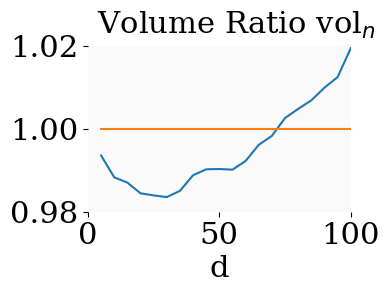

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Palatio']
rcParams['text.usetex'] = False

fig, ax = plt.subplots(figsize=(4,2.9))

fontsize = 22

## do plotting here
dimensionality = np.arange(5,105,5)
ax.plot(dimensionality,[(LP_0_dims[j])/relu_dims[j] for j in range(len(dimensionality))],label = 'LP')
ax.plot(dimensionality,[ relu_dims[j] /relu_dims[j] for j in range(len(dimensionality))],label = 'CURLS')

# ax.legend(fontsize=fontsize,bbox_to_anchor=(1.05, 0.5), loc='center left')
ax.set_xlim([0,100])
ax.set_ylim([0.98,1.02])

plt.ylabel(r" Volume Ratio vol$_{n}$",rotation=0 , fontsize=fontsize,ha="left")
ax.yaxis.set_label_coords(0.0, 1.03)
plt.xlabel(r"d", fontsize=fontsize)
plt.xticks(np.arange(0,105,50))
temp = np.arange(0.98,1.025,0.02)
plt.yticks(temp)
ax.set_facecolor( (0.98, 0.98, 0.98) )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
fig.tight_layout()


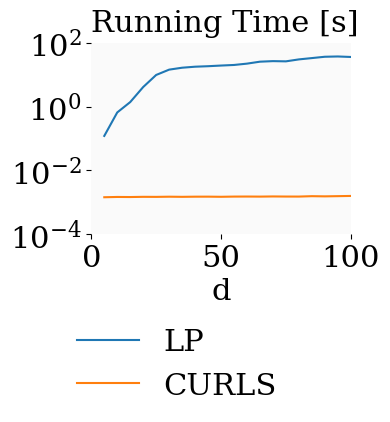

In [6]:
fig, ax = plt.subplots(figsize=(4,4.9))
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Palatio']
rcParams['text.usetex'] = False
fontsize = 22

## do plotting here
dimensionality = np.arange(5,105,5)
ax.plot(dimensionality,(LP_0_times[0:len(dimensionality)]),label = 'LP')

ax.plot(dimensionality,relu_times[0:len(dimensionality)],label = 'CURLS')
ax.set_xlim([0,100])

plt.ylabel(r"Running Time [s]",rotation=0 , fontsize=fontsize,ha="left")
ax.yaxis.set_label_coords(0.0, 1.03)
ax.set_yscale("log")
plt.xlabel(r"d", fontsize=fontsize)
plt.xticks(np.arange(0,105,50))
#plt.yticks(np.arange(0.0001,2.1,1))
plt.yticks([0.0001,0.01,1,100])
ax.legend(loc='upper center', bbox_to_anchor=(0.33, -0.35),fancybox=False, shadow=False, frameon = False, ncol=1,fontsize = fontsize)

ax.set_facecolor( (0.98, 0.98, 0.98) )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
fig.tight_layout()
